# Network Infrastructure


### Description

Network topology is at the heart of today's hierarchacal internet infrastructure, from connecting machines in an office to datacenters between continients. ISP and private companies would like to provide connectivity and performance while reducing the amount of infrastructure and overall costs they must incur.

We consider the task of a major Internet company (e.g. Google) or cable company tasked with the role of connecting major cities across the US. The company is seeking to install fiber optic cables between major cities (e.g. connecting data centers). However, installing network cables are no cheap feat, so there are incentives to reducing the amount of cabling used. However, the company would also like to maximize performance by reducing/controlling latency. 

A network of routers which send packets from one router to another. In reality, the path that an Internet packet can follow across this hierarchacal network can very unpredictable due to various routing protocols and packet switching between multiple organizations. However, on our organization's fiber optic network, we assume that packets received at one data center will be routed on the "shortest path" across our network (which we know a-priori) to the destination data center (before being passed on to the local routers). 

Options to rent

Our choice of sample cities is based upon Amazon's current distribution of US-based data centers and CDNs, including many major US cities and regions where key datacenters and cloud services are based. We have removed several cities which were located closely to other cities (within 50 miles, such as San Jose, CA) and added several other major cities for analytical purposes

### A Brief History


### Importance, Relevance


### Assumtions

We will operate under the generalization that each mile of fiber optic installation costs \$50,000. This estimate excludes all fixed and long term costs of maintainance, management, etc.

We also assume that the fiber optic cables can be run directly between locations in a "straight" line (on a curved Earth). This means we ignore the ramifications of infrastructure, geography, and socioeconomic policy which would affect the costs and feasibility of these installation routes. For our distance measures between locations, we use the Vincenty formula, which approximates straight line distances on an elipsoidal Earth. 

In [1]:
using JuMP
using Ipopt
using Clp
using NamedArrays
using PyPlot
using Interact

In [3]:
# Amazon
centers = [
    "Ashburn, VA",
    "Atlanta, GA",
    "Chicago, IL",
    "Dallas/Fort Worth, TX",
    "Jacksonville, FL",
    "Los Angeles, CA",
    "Miami, FL",
    "New York, NY",
    "Palo Alto, CA",
    "Seattle, WA",
    "South Bend, IN",
    "St. Louis, MO",
    "Boardman, OR",
];

raw = [
    0 530.09 568.43 1173.61 645.49 2274.22 927.81 219.44 2408.07 2301.47 496.75 685.79 2181.78; 
    530.09 0 587.61 734.14 284.9 1936.72 604.25 747.91 2127.93 2182.0 556.57 467.22 2034.73 ;
    568.43 587.61 0 809.46 862.54 1745.96 1188.01 713.32 1854.17 1737.66 72.23 262.15 1614.39; 
    1173.61 734.14 809.46 0 922.51 1225.95 1125.18 1384.13 1453.2 1668.59 850.49 553.85 1500.59; 
    645.49 284.9 862.54 922.51 0 2147.67 326.31 836.25 2360.7 2455.02 823.52 750.69 2304.03 ;
    2274.22 1936.72 1745.96 1225.95 2147.67 0 2339.02 2451.84 320.99 958.82 1814.78 1589.42 816.75;
    927.81 604.25 1188.01 1125.18 326.31 2339.02 0 1090.82 2578.14 2733.5 1149.82 1060.41 2576.42 ;
    219.44 747.91 713.32 1384.13 836.25 2451.84 1090.82 0 2567.48 2408.45 641.93 874.99 2300.21; 
    2408.07 2127.93 1854.17 1453.2 2360.7 320.99 2578.14 2567.48 0 701.45 1925.71 1736.84 593.33; 
    2301.47 2182.0 1737.66 1668.59 2455.02 958.82 2733.5 2408.45 701.45 0 1807.53 1724.02 174.48 ;
    496.75 556.57 72.23 850.49 823.52 1814.78 1149.82 641.93 1925.71 1807.53 0 296.82 1685.43; 
    685.79 467.22 262.15 553.85 750.69 1589.42 1060.41 874.99 1736.84 1724.02 296.82 0 1582.46; 
    2181.78 2034.73 1614.39 1500.59 2304.03 816.75 2576.42 2300.21 593.33 174.48 1685.43 1582.46 0;
];

distance = NamedArray(raw, (centers,centers), ("from","to"))
n = length(centers)

data = [
    39.0437192 -77.4874898;
    33.7490987 -84.3901848;
    41.8755546 -87.6244211;
    32.837113 -97.0363141;
    30.3321838 -81.6556509;
    34.0543942 -118.2439408;
    25.7742658 -80.1936588;
    40.7305991 -73.9865811;
    37.442156 -122.1634471;
    47.6038321 -122.3300623;
    41.6833813 -86.2500065;
    38.6272733 -90.1978888;
    45.839855 -119.7005833;
]
lat = Dict(zip(centers,data[:,1]));
lon = Dict(zip(centers,data[:,2]));

In [74]:
# Zayo Data centers
centers = [
    "Ashburn, VA", 
    "Atlanta, GA",
    "Austin, TX",
    "Boise, ID",
    "Boston, MA",
    "Chicago, IL",
    "Cincinnati, OH",
    "Dallas, TX",
    "Denver, CO",
    "Las Vegas, NV",
    "Los Angeles, CA",
    "Miami, FL", 
    "Minneapolis, MN",
    "Nashville, TN",
    "New York, NY",
    "Palo Alto, CA",
    "Seattle, WA"
];

raw = [
0 530.09 1298.47 2019.68 407.64 568.43 377.67 1163.11 1466.9 2061.18 2274.22 927.81 907.4 546.61 219.44 2408.07 2301.47 
530.09 0 819.05 1835.68 936.77 587.61 369.12 720.98 1211.82 1746.3 1936.72 604.25 907.48 214.41 747.91 2127.93 2182.0 
1298.47 819.05 0 1369.13 1695.9 978.7 966.71 181.41 770.49 1084.97 1227.24 1114.85 1043.11 753.26 1514.07 1483.42 1770.16 
2019.68 1835.68 1369.13 0 2260.77 1451.59 1666.27 1288.75 638.33 517.03 668.68 2363.43 1137.39 1636.24 2153.05 528.88 404.84 
407.64 936.77 1695.9 2260.77 0 850.51 740.15 1551.6 1769.63 2375.49 2596.47 1255.68 1123.74 942.98 188.88 2695.68 2492.19 
568.43 587.61 978.7 1451.59 850.51 0 251.98 804.53 920.44 1525.31 1745.96 1188.01 355.4 396.76 713.32 1854.17 1737.66 
377.67 369.12 966.71 1666.27 740.15 251.98 0 814.07 1093.91 1684.43 1896.68 952.06 605.37 237.64 570.01 2035.78 1971.4 
1163.11 720.98 181.41 1288.75 1551.6 804.53 814.07 0 662.38 1071.64 1240.4 1110.68 862.67 617.53 1374.14 1467.73 1681.41 
1466.9 1211.82 770.49 638.33 1769.63 920.44 1093.91 662.38 0 606.85 831.19 1725.4 699.41 1022.67 1632.05 941.87 1021.34 
2061.18 1746.3 1084.97 517.03 2375.49 1525.31 1684.43 1071.64 606.85 0 227.85 2181.13 1296.22 1580.67 2234.21 398.66 871.0 
2274.22 1936.72 1227.24 668.68 2596.47 1745.96 1896.68 1240.4 831.19 227.85 0 2339.02 1523.57 1780.85 2451.84 320.99 958.82 
927.81 604.25 1114.85 2363.43 1255.68 1188.01 952.06 1110.68 1725.4 2181.13 2339.02 0 1511.2 814.76 1090.82 2578.14 2733.5 
907.4 907.48 1043.11 1137.39 1123.74 355.4 605.37 862.67 699.41 1296.22 1523.57 1511.2 0 697.01 1019.23 1583.16 1395.08 
546.61 214.41 753.26 1636.24 942.98 396.76 237.64 617.53 1022.67 1580.67 1780.85 814.76 697.01 0 760.88 1952.83 1974.66 
219.44 747.91 1514.07 2153.05 188.88 713.32 570.01 1374.14 1632.05 2234.21 2451.84 1090.82 1019.23 760.88 0 2567.48 2408.45 
2408.07 2127.93 1483.42 528.88 2695.68 1854.17 2035.78 1467.73 941.87 398.66 320.99 2578.14 1583.16 1952.83 2567.48 0 701.45 
2301.47 2182.0 1770.16 404.84 2492.19 1737.66 1971.4 1681.41 1021.34 871.0 958.82 2733.5 1395.08 1974.66 2408.45 701.45 0
];

distance = NamedArray(raw, (centers,centers), ("from","to"))
n = length(centers)

data = [
39.0437192 -77.4874898;
33.7490987 -84.3901848;
30.2711286 -97.7436994;
43.61656 -116.2008349;
42.3604823 -71.0595677;
41.8755546 -87.6244211;
39.1014537 -84.5124601;
32.7762719 -96.7968558;
39.7391536 -104.9847033;
36.1662859 -115.1492249;
34.0543942 -118.2439408;
25.7742658 -80.1936588;
44.9772995 -93.2654691;
36.1622296 -86.774353;
40.7305991 -73.9865811;
37.442156 -122.1634471;
47.6038321 -122.3300623;
];
lat = Dict(zip(centers,data[:,1]));
lon = Dict(zip(centers,data[:,2]));

In [16]:
# Min data set for testing

centers = ["Boston","LA","Chicago","Dallas"];

raw = [
    0 2600 850 1500;
    2600 0 1700 1300; 
    850 1700 0 805;
    1500 1300 805 0;
];

distance = NamedArray(raw, (centers,centers), ("from","to"));
n = length(centers);

data = [ 
    42.3601 -71.0589;
    34.0522 -118.2437;
    41.8781 -87.6298;
    32.7767 -96.7970;
];
lat = Dict(zip(centers,data[:,1]));
lon = Dict(zip(centers,data[:,2]));



# Optimal Min Cost

## Min Spanning Tree
http://www.columbia.edu/~cs2035/courses/ieor6614.S16/mst-lp.pdf

Trees of n nodes must have exactly n-1 edges. 

To prevent disconnected components, we use a subtour elimination constraint that prevents cycles. To do so, we consider every possible subset of nodes S and require that the induced subgraph (that is, the subgraph with edges only between these points) must have less than $|S|-1$ edges. This does require us to generate and enummerate $2^{n}$ constraints since there are $2^{n}$ possible subsets

In [17]:
# Ennumerative Subset approach
function genSubsets(nn)
    if (nn==1)
        return Array[[1],[]]
    else
        sol = genSubsets(nn-1);
        for i in 1:length(sol)
            push!(sol,[sol[i];nn])
        end
        return sol
    end
end

genSubsets (generic function with 1 method)

In [18]:
m = Model();
@variable(m, edge[centers,centers], Bin)
@constraint(m, sum(edge) == n-1) # Min spanning tree requirement
@objective(m, Min, sum{edge[i,j]*distance[i,j], i in centers, j in centers})
for i in centers
    @constraint(m,edge[i,i]==0)
end
subsets = genSubsets(n)
for arr in subsets
    L = length(arr)
    if L > 1
        @constraint(m, sum{ edge[centers[i],centers[j]], i in arr, j in arr } <= L-1)
    end
end
solve(m)
#println(getvalue(edge))
println(getobjectivevalue(m))

2955.0


In [121]:
# US Map plotter
using PyPlot
using PyCall
@pyimport mpl_toolkits.basemap as basemap

function interactiveSet()
    intMap=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=23,llcrnrlon=-126,urcrnrlat=50,urcrnrlon=-70)
    intMap[:drawmapboundary](fill_color="#4771a5")
    intMap[:fillcontinents](color="#555555")

    # plot airports
    for i in centers
        intMap[:plot](lon[i], lat[i], "ro" ,latlon=true)
    end
end

function interactivePlot(x=0, y=0)
    for i in centers
        for j in centers
            if x[i,j] > 0.9
                intMap[:drawgreatcircle](lon[i],lat[i],lon[j],lat[j],linewidth=1,color="b")
            end
            if y[i,j] > 0.9
                intMap[:drawgreatcircle](lon[i],lat[i],lon[j],lat[j],linewidth=1,color="g")
            end
        end
    end
end

function mapSolution(x=0, y=0)
    m=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=23,llcrnrlon=-126,urcrnrlat=50,urcrnrlon=-70)
    m[:drawmapboundary](fill_color="#4771a5")
    m[:fillcontinents](color="#555555")

    # plot airports
    for i in centers
        m[:plot](lon[i], lat[i], "ro" ,latlon=true)
    end
    
    for i in centers
        for j in centers
            if x[i,j] > 0.9
                m[:drawgreatcircle](lon[i],lat[i],lon[j],lat[j],linewidth=1,color="b")
            end
            if y[i,j] > 0.9
                m[:drawgreatcircle](lon[i],lat[i],lon[j],lat[j],linewidth=1,color="g")
            end
        end
    end
end
;

function mapSolution(x=0)
    m=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=23,llcrnrlon=-126,urcrnrlat=50,urcrnrlon=-70)
    m[:drawmapboundary](fill_color="#4771a5")
    m[:fillcontinents](color="#555555")

    # plot airports
    for i in centers
        m[:plot](lon[i], lat[i], "ro" ,latlon=true)
    end
    
    for i in centers
        for j in centers
            if x[i,j] > 0.9
                m[:drawgreatcircle](lon[i],lat[i],lon[j],lat[j],linewidth=1,color="b")
            end
        end
    end
end
;
# mapSolution(getvalue(edge))

# Connected graphs

Here, we attempt to calculate the optimium subgraph using a network flow "subproblem". Here, we attempt to find a subgraph with all vertices for which there exists atleast 1 path from a chosen node to every other node, implying that the subgraph is connected. To do so, we fix some node as a source with supply flow of n-1 units. Then we then set every other node as a sink with demand of 1 unit. Every edge can have unlimited flow across it. The only way for this supply and demand to be satisfied is for the supply to be distributed across all nodes, each consuming 1 unit of this flow; that is, there must exist atleast 1 path for the flow from this source to every sink. Hence, we much choose edges in our subgraph such that this flow problem "constraints" have some solution, implying connectivity. To achieve the cheapest such subgraph, we minimize the weighed sum of the edges chosen with their weights.

We make a quick note that because we are allowing connections between any pairs of cities/nodes, we are considering any edges between any nodes $i,j \in V$ (as opposed to $i,j \in V$ s.t. $(i,j) \in E$, which is equivalent but for general graphs.)

# Model
## Objective function:

Decision variables:
We use $x_{i,j}$ as an indicator whether the edge from i to j is included within our subgraph solution. This is a binary indicator variable 
$x_{i,j} \in {0,1},\forall i,j \in V$

We use a nonnegative variable to encode information about the network flow between nodes i and j, as part of the connectivity solution.
$flow_{i,j} \geq 0,\forall i,j \in V$

Our choice of edges in our subgraph seeks to minimize the total cost, or equivalently, the total distance across all included edge weights. To do so, we calculate the weighted sum of each edges' weight with $x_{i,j}$, the binary indicator of whether it is included in our subgraph.

min $\sum_{i \in V}\sum_{j \in V}c_{i,j}*x_{i,j}$ 


Constraints:

We do not want to consider self loops on nodes as prospective edges.
$x_{i,i}=0,\forall i \in V$
$flow_{i,i}=0,\forall i \in V$

For node 1, we have a source node with n-1 unit supply. We utilize the conservation of flow equations to form this constraint:
$(n-1)+\sum_{j \in V} flow_{j,1}*x_{j,1}-\sum_{j \in V} flow_{1,j}*x_{1,j} = 0$

For all nodes $i \in V$ with $i \neq 1$
$\sum_{j \in V} flow_{j,i}*x_{j,i}-\sum_{j \in V} flow_{i,j}*x_{i,j} = 1$

We would like to encode the following constaint to force flows only over edges that are "included". That is:
If there exists a flow from nodes i to j for $i,j \in V$, then $x_{i,j}=1$

Noting that the max flow over any edge is n-1 because there is only n-1 supply over the whole network (from node 1), we can use this as an upper limit to write an equivalent inequality constraint:
$(n-1)*x_{i,j} >= flow_{i,j}$ for all $i,j \in V$

5988.549999999999


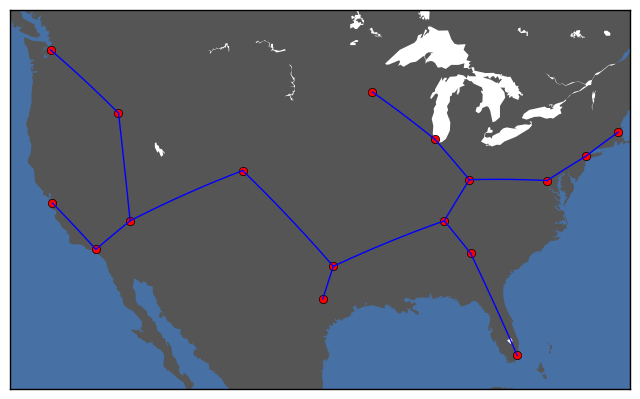

In [76]:
m = Model()
@variable(m, edge[centers,centers], Bin)

#Connectivity requirement
@variable(m, flow[centers,centers] >=0) #how much flow over edge (no upper limit)
for i in centers
    @constraint(m, edge[i,i]==0)
    @constraint(m, flow[i,i]==0)
    for j in centers
        @constraint(m,flow[i,j] <= (n-1)*edge[i,j]) # encodes "if flow >0, then edge==1" 
    end
    
    if (i==centers[1])
        @constraint(m, n-1 + sum{flow[c,i], c=centers} - sum{flow[i,c], c in centers} == 0) # center 1 has (n-1 inflow,)
    else
        @constraint(m, sum{flow[c,i], c=centers}-sum{flow[i,c], c in centers} == 1) #Every other node has 1 outflow
    end
end

@objective(m, Min, sum{edge[i,j]*distance[i,j], i in centers, j in centers})
#Connectivity constraint as a max-flow problem.

s=solve(m)
#println(getvalue(edge))
println(getobjectivevalue(m))
mapSolution(getvalue(edge))

Total Cost: 9999.84
Total length of Cable2: 4011.29


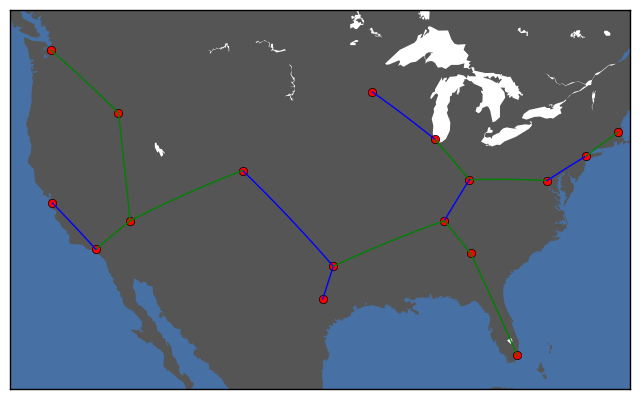

In [134]:
edgeResult = getvalue(edge) # edgeResult is the edges from the previous model, shortest distance to cover all the cities

# Cost for the cables per mile and the budget
cost1 = 1 
cost2 = 2
budget = 10000

m2 = Model()

# Edges for different cables, edge1 = cable1, edge2 = cable2
@variable(m2, edge1[centers,centers], Bin)
@variable(m2, edge2[centers,centers], Bin)

# Constraint to make sure that all the edges are filled up by cables
@constraint(m2, c1[i in centers, j in centers], edge1[i,j] + edge2[i,j] == edgeResult[i,j])

# Cost for the cables
@expression(m2, cost, sum{edge1[i,j]*distance[i,j]*cost1 + edge2[i,j]*distance[i,j]*cost2, i in centers, j in centers})

# Cost have to be less than budget
@constraint(m2, cost <= budget)

# Maximize the length of cable2 because cable2 is of better quality
@objective(m2, Max, sum{edge2[i,j]*distance[i,j], i in centers, j in centers})

s=solve(m2)

println("Total Cost: ", getvalue(cost))
println("Total length of Cable2: ", getobjectivevalue(m2))

mapSolution(getvalue(edge1), getvalue(edge2))

## Diameter Constrainted

Latency issues can arise if data must be routed indirectly before reaching its destination. To meet performance requirements, we may like to restrict the max distance any data must travel between centers.

Here, we would like to extend the above problem to restrict the diameter of the subgraph to some maximum distance. That is, the minimum distance between any 2 vertices along the subgraph must not exceed this value.

http://www.dcc.ic.uff.br/~celso/artigos/cpdcmst.pdf


NaN


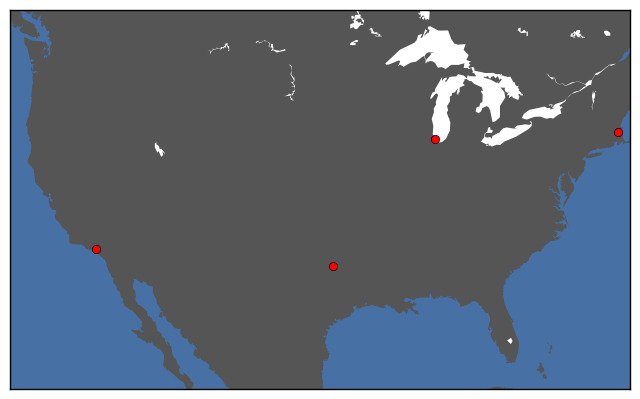

In [21]:
# Even D case
D = 5;
L = D/2;
m = Model()
@variable(m, edge[centers,centers], Bin)
@variable(m, 0 <= u[centers,centers] <= D+1)


#Connectivity requirement
@variable(m, flow[centers,centers] >=0) #how much flow over edge (no upper limit)
for i in centers
    @constraint(m, edge[i,i]==0)
    @constraint(m, flow[i,i]==0)
    for j in centers
        @constraint(m,flow[i,j] <= (n-1)*edge[i,j]) # encodes "if flow >0, then edge==1" 
    end
    
    if (i==centers[1])
        @constraint(m, n-1 - sum{flow[i,c], c in centers} ==0) # center 1 has (n-1 inflow,)
    else
        @constraint(m, sum{flow[c,i], c=centers}-sum{flow[i,c], c in centers}==1) #Every other node has 1 outflow
    end
end


#@constraint(m, sum(r_edge)==1);
#for j in centers
#    @constraint(m,sum{edge[i,j],i in centers}+r_edge["r",j]==1);
#end
for start in centers
    #@constraint(m, u[start,start] == 0.0 )
    for i in centers
        for j in centers
            @constraint(m, u[start,i]-u[start,j]+(D+distance[i,j])*edge[i,j] <= D);
        end
    end
end
#for j in centers
#    @constraint(m, u["r"]-u[j]+(L+1)*r_edge["r",j] <= L);
#end

for i in centers
    @constraint(m,edge[i,i]==0)
end

@objective(m, Min, sum{edge[i,j]*distance[i,j], i in centers, j in centers})

s=solve(m)
#println(getvalue(edge))
println(getobjectivevalue(m))
mapSolution(getvalue(edge))

# Odd D case



In [22]:
print(getvalue(u))
print(L)

u: 2 dimensions:
[ Boston,:]
  [ Boston, Boston] = NaN
  [ Boston,     LA] = NaN
  [ Boston,Chicago] = NaN
  [ Boston, Dallas] = NaN
[     LA,:]
  [     LA, Boston] = NaN
  [     LA,     LA] = NaN
  [     LA,Chicago] = NaN
  [     LA, Dallas] = NaN
[Chicago,:]
  [Chicago, Boston] = NaN
  [Chicago,     LA] = NaN
  [Chicago,Chicago] = NaN
  [Chicago, Dallas] = NaN
[ Dallas,:]
  [ Dallas, Boston] = NaN
  [ Dallas,     LA] = NaN
  [ Dallas,Chicago] = NaN
  [ Dallas, Dallas] = NaN
2.5

## Average Distance

## Minimum Spanning Forest

While unlikely on local scale, globally, it may not be necessary to share data across different regions between which users are less likely to interact or share data (e.g. user accounts, news, clouds storage are generally local to user). Instead of installing dedicated network cables, it may be more efficient and cost effective to rent/utilize existing cable infrastructure (e.g. send data across other non-dedicated ISPs).

## Budget constraints

# Conclusions